In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
import numpy_financial as npf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

## Optimize Portfolio Weights through Historical Data and Test it

The below is a practice of optimizing portfolio weights utilizing historical data and testing // utilizing IRR calc of prev. DCA analysis (could be stock but I can only trade ETFs)
I wanted to analyze:
1) What is the utlimate mix of weights of given portfolio (lowest risk, highest return) 
2) Whether Portoflio composition based on Historical Data promise a return

Futher project ideas include:
1) Whether specific day of the month would give higher IRR (that is significant enough to impact the decision)
    - reasoning behind the test would be some belief that "at the end of the month, it always go up!" kinda deal
2) R^2 of two ETFs - so that i can see how much correlated they are (also look at covariance) - for portfolio selection
    
    
Other questions include:
1) Is STD a good way to test volatility? What are other ways of testing RISK for investors?
2) Would there be a ML way / more quantitative way of find the best portfolio?


Inputs Below

In [81]:
# Define a list of ETF symbols including a T-Bill ETF
etf_symbols = ['SPY','QQQ', 'SCHD', 'ICSH', 'MGV','PULS','SCHO','SPLB']

# Define the initial start date and end dates for training and testing periods
train_start_date = '2015-01-01'
train_end_date = '2018-12-01'
test_start_date = '2021-01-01'
test_end_date = '2022-12-01'
#test_end_date = datetime.today().strftime('%Y-%m-%d')

# Risk-free rate (annualized yield of 3-month T-bill)
risk_free_rate = 0.025

Functions Below

In [82]:
def get_earliest_date(etf):
    ticker = yf.Ticker(etf)
    history = ticker.history(period="max")
    if not history.empty:
        return history.index.min()
    else:
        raise ValueError(f"No historical data found for {etf}")

def get_previous_business_day(date, data):
    """Find the nearest previous business day in the data."""
    while date not in data.index:
        date -= timedelta(days=1)
        if date.weekday() == 5:  # Saturday
            date -= timedelta(days=1)
        elif date.weekday() == 6:  # Sunday
            date -= timedelta(days=2)
        if date < data.index.min():
            raise ValueError(f"No valid business days found for {date}")
    return date

def calculate_irr_with_dca(etf, etf_data, initial_start_date, end_date):
    
    if etf_data.empty:
        raise ValueError(f"No data for ETF {etf} in the specified period")
    
    # Generate all monthly dates from start date until end date
    # Get the inception date
    inception_date = get_earliest_date(etf)
    inception_date = inception_date.tz_localize(None)  # Ensure timezone-naive - okay, this actually not sure but got some help from internet
    start_date = max(pd.to_datetime(initial_start_date), inception_date)
    investment_dates = pd.date_range(start=start_date, end=end_date, freq='M')
    
    # Calculate DCA investments with annual increase
    investments = []
    total_shares = 0
    current_investment_amount = initial_investment_amount
    for i, date in enumerate(investment_dates):
        try:
            date = get_previous_business_day(date, etf_data)
            close_price = etf_data.loc[date]
            shares = current_investment_amount / close_price
            total_shares += shares
            investments.append((date, shares, current_investment_amount))

            # Increase the investment amount every 12 months (yearly)
            if (i + 1) % 12 == 0:
                current_investment_amount *= (1 + annual_increase_rate)

        except ValueError as e:
            print(f"Skipping date {date}: {e}")

    # Calculate the final value of the DCA investment
    final_value_dca = total_shares * etf_data.loc[get_previous_business_day(investment_dates[-1], etf_data)]

    # Create cash flows list for DCA
    dca_cash_flows = [-initial_investment_amount * (1 + annual_increase_rate) ** (i // 12) for i in range(len(investment_dates))] + [final_value_dca]
    
    # Calculate IRR for DCA
    irr_monthly = npf.irr(dca_cash_flows)
    irr_annual = (1 + irr_monthly) ** 12 - 1
    return irr_annual


# Define optimization functions
def portfolio_annualized_performance(weights, expected_returns, cov_matrix):
    returns = np.sum(expected_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    std, returns = portfolio_annualized_performance(weights, expected_returns, cov_matrix)
    return - (returns - risk_free_rate) / std

def minimize_volatility(weights, expected_returns, cov_matrix):
    std, returns = portfolio_annualized_performance(weights, expected_returns, cov_matrix)
    return std


Train it (get optimale weights of the training data)

In [83]:
# Fetch adjusted close prices for each ETF (includes dividends)
etf_data = {}
for etf in etf_symbols:
    etf_data[etf] = yf.download(etf, start=train_start_date, end=test_end_date)['Adj Close']

# Separate the data into training and testing periods
train_data = {etf: etf_data[etf][train_start_date:train_end_date] for etf in etf_symbols}
test_data = {etf: etf_data[etf][test_start_date:test_end_date] for etf in etf_symbols}

# Calculate daily returns for training period
train_returns = pd.DataFrame()
for etf in etf_symbols:
    train_returns[etf] = train_data[etf].pct_change()

# Remove NaN values from training returns
train_returns.dropna(inplace=True)

# Calculate IRR for training period
initial_investment_amount = 1000
annual_increase_rate = 0.02

# Calculate IRR for each ETF in the training period
annual_returns_train = {}
for etf in train_data:
    try:
        irr = calculate_irr_with_dca(etf, train_data[etf], train_start_date, train_end_date)
        annual_returns_train[etf] = irr
    except ValueError as e:
        print(f"Skipping ETF {etf} due to error: {e}")

# Convert annual returns to a numpy array for optimization
expected_returns_train = np.array(list(annual_returns_train.values()))

# Calculate the covariance matrix for the training period
cov_matrix_train = train_returns.cov() * 252  # Annualized covariance matrix

# Constraints and bounds for the optimization
lower_bound = 0.025
weight_cap = 0.3
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((lower_bound, weight_cap) for _ in range(len(etf_symbols)))

# Initial guess (equal distribution)
init_guess = len(etf_symbols) * [1. / len(etf_symbols)]

# Optimize for maximum Sharpe ratio on training data
optimal_sharpe_train = minimize(negative_sharpe_ratio, init_guess, args=(expected_returns_train, cov_matrix_train, risk_free_rate),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal weights from the training period
optimal_sharpe_weights_train = optimal_sharpe_train.x

# Print the training results
print("Performance on Training Period using Optimal Weights from Training Period")
optimal_weights_percent = optimal_sharpe_weights_train * 100
for ticker, weight in zip(etf_symbols, optimal_weights_percent):
    print(f"{ticker}: {weight:.2f}%")

# Evaluate portfolio performance on training period 
portfolio_std_train, portfolio_return_train = portfolio_annualized_performance(optimal_sharpe_weights_train, expected_returns_train, cov_matrix_train)
sharpe_ratio_train = (portfolio_return_train - risk_free_rate) / portfolio_std_train

print(f"\nTraining Period Portfolio Expected Return with Weight Cap: {portfolio_return_train:.4f}")
print(f"Training Period Portfolio Expected Volatility with Weight Cap: {portfolio_std_train:.4f}")
print(f"Training Period Portfolio Sharpe Ratio with Weight Cap: {sharpe_ratio_train:.4f}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Performance on Training Period using Optimal Weights from Training Period
SPY: 2.50%
QQQ: 21.47%
SCHD: 30.00%
ICSH: 2.50%
MGV: 30.00%
PULS: 8.53%
SCHO: 2.50%
SPLB: 2.50%

Training Period Portfolio Expected Return with Weight Cap: 0.1072
Training Period Portfolio Expected Volatility with Weight Cap: 0.1071
Training Period Portfolio Sharpe Ratio with Weight Cap: 0.7674


C:\Users\boost\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [84]:
# Evaluate the performance on the testing period
test_returns = pd.DataFrame()
for etf in etf_symbols:
    test_returns[etf] = test_data[etf].pct_change()

# Remove NaN values from testing returns / Calculate Covariance
test_returns.dropna(inplace=True)
cov_matrix_test = test_returns.cov() * 252

# Evaluate the returns on the testing period
annual_returns_test = {etf: calculate_irr_with_dca(etf, test_data[etf], test_start_date, test_end_date) for etf in etf_symbols}
expected_test_returns = np.array(list(annual_returns_test.values()))

# Calculate performance on the testing period using optimal weights from training period
#TODO
portfolio_return_test, portfolio_std_test = portfolio_annualized_performance(optimal_sharpe_weights_train, expected_test_returns, cov_matrix_test)

# Print the results
print("Performance on Testing Period using Optimal Weights from Training Period")
#optimal_weights_percent = optimal_sharpe_weights_train * 100
#for ticker, weight in zip(etf_symbols, optimal_weights_percent):
#    print(f"{ticker}: {weight:.2f}%")
sharpe_ratio_test = (portfolio_return_test - risk_free_rate) / portfolio_std_test
print(f"Expected Return: {portfolio_return_test:.4f}")
print(f"Expected Volatility: {portfolio_std_test:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio_test:.4f}")

Performance on Testing Period using Optimal Weights from Training Period
Expected Return: 0.1466
Expected Volatility: 0.0282
Sharpe Ratio: 4.3057


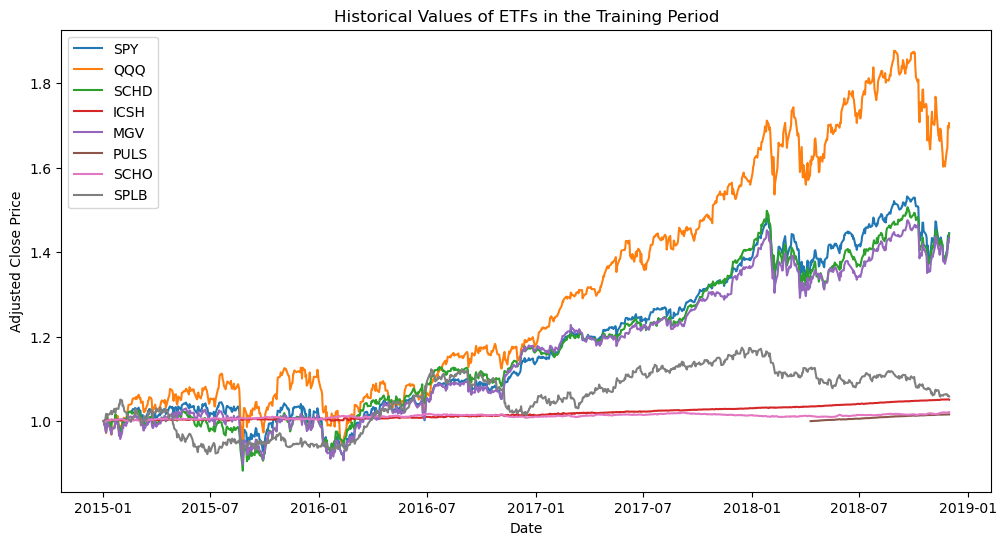

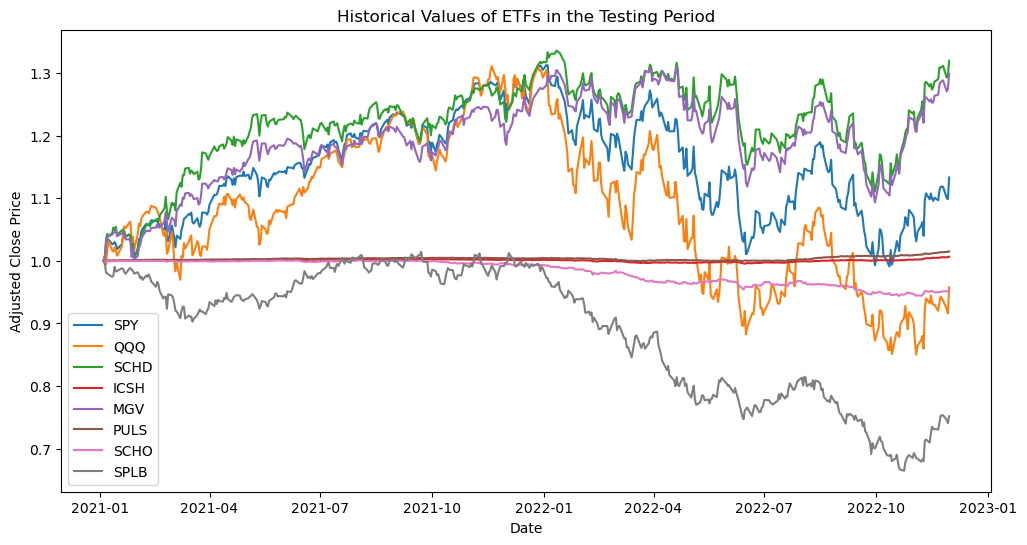

In [85]:
# Plot historical values of each ETF in the training period
train_normalized_data = pd.DataFrame()
test_normalized_data = pd.DataFrame()

for etf in etf_symbols:
    train_normalized_data[etf] = train_data[etf] / train_data[etf].iloc[0]
    test_normalized_data[etf] = test_data[etf] / test_data[etf].iloc[0]
    
plt.figure(figsize=(12, 6))
for etf in etf_symbols:
    plt.plot(train_normalized_data[etf].index, train_normalized_data[etf], label=etf)
plt.title('Historical Values of ETFs in the Training Period')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Plot historical values of each ETF in the testing period
plt.figure(figsize=(12, 6))
for etf in etf_symbols:
    plt.plot(test_normalized_data[etf].index, test_normalized_data[etf], label=etf)
plt.title('Historical Values of ETFs in the Testing Period')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()